# Violence Recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
cd /content/drive/My\ Drive/Violence_detection/

/content/drive/My Drive/Violence_detection


## Keras Sequence Video generators for Training data

**SlidingFrameGenerator** that takes frames with decay for the entire video or with a sequence time

Used SlidingFrameGenerator to train this model. It will give you more samples because we can get shifted frame.

Instead of taking frames from zero to end, we can define the “time of movement” (sequence_time) and get N frames in that time.

The VideoFrameGenerator can be installed via pip command:

In [4]:
!pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12883 sha256=7f1e52f711d344bd4d588f953d2717407558e03a34831a525a2c622a336ec14e
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
import os
import glob
from keras_video import VideoFrameGenerator
from keras_video import SlidingFrameGenerator
classes = [i.split(os.path.sep)[1] for i in glob.glob('Res_videos/*')]
classes.sort() 

Using TensorFlow backend.


Video frame generator can take ImageDataGenerator to produce data augmented frameset from the input videos.

In [ ]:
import keras
SIZE = (224, 224)
H, W = 224, 224
CHANNELS = 3
NBFRAME = 8
BS = 4

# pattern to get videos and classes
glob_pattern='Res_videos/{classname}/*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=[0.5,0.9],
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

train = SlidingFrameGenerator(
    sequence_time = 1,
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.1, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class nonviolence, validation count: 57, train count: 519
class violence, validation count: 130, train count: 1174
Total data: 2 classes for 1693 files for train
Checking files to find possible sequences, please wait...
For 1693 files, I found 107711 possible sequence samples


In [ ]:
valid = train.get_validation_generator()

Total data: 2 classes for 187 files for validation
Checking files to find possible sequences, please wait...
For 187 files, I found 11730 possible sequence samples


In [ ]:
import keras_video.utils
keras_video.utils.show_sample(train,random=True)

# **Training**
Pre-trained VGG network used for feature extraction.

In [ ]:
import keras.backend as K
from keras.layers import Bidirectional
from keras.layers import TimeDistributed, GRU, Dense, Dropout, LSTM, ConvLSTM2D

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def build_vggnet(shape=(H, W, 3)):
    model = keras.applications.VGG16(include_top=False, input_shape=shape, weights='imagenet')
    for layer in model.layers:
        layer.trainable = False
    output = keras.layers.GlobalMaxPool2D()
    return keras.Sequential([model,output])

CHANNELS = 3

def action_model(shape=(NBFRAME, H, W, 3), nbout=2):
    convnet = build_vggnet(shape[1:])
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    model.add(Bidirectional(LSTM(64, return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))
model.summary()
optimizer = keras.optimizers.Adam(learning_rate=0.001) #keras.optimizers.SGD()
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc',f1_score]
)

model.load_weights('NCKPT/weights-new8ND.40-0.16.hdf5')

EPOCHS=1000

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1),
    keras.callbacks.ModelCheckpoint(
        'July16/VGG-SND.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True,
        verbose=1),
]
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    steps_per_epoch=6000,
    callbacks=callbacks
)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 8, 512)            14714688  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 8, 128)            295424    
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

# **Inference**
Testing the model using test data
Test Data location : 'TData/'


In [5]:
import os
import glob
from keras_video import VideoFrameGenerator
from keras_video import SlidingFrameGenerator
classes = [i.split(os.path.sep)[1] for i in glob.glob('TData/*')]
classes.sort()

Using TensorFlow backend.


Loding the test data using video frame generator

Loading the checkpoint and testing

In [7]:
import keras.backend as K
from keras.layers import Bidirectional
from keras.layers import TimeDistributed, GRU, Dense, Dropout, LSTM

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def build_vggnet(shape=(H, W, 3)):
    model = keras.applications.VGG16(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 9 layers to train﻿﻿
    # trainable = 9
    for layer in model.layers:
        layer.trainable = False
    # for layer in model.layers[-trainable:]:
    #     layer.trainable = True
    output = keras.layers.GlobalMaxPool2D()
    return keras.Sequential([model, output])
CHANNELS = 3

def action_model(shape=(NBFRAME, H, W, 3), nbout=2):
    convnet = build_vggnet(shape[1:])
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(Bidirectional(LSTM(64, return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))

optimizer = keras.optimizers.Adam(learning_rate=0.001) #keras.optimizers.SGD()
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc',f1_score]
)

model.load_weights('July16/VGG-SND.03-0.24.hdf5')

58892288/58889256 [==============================] - 3s 0us/step


In [78]:
import keras
SIZE = (224, 224)
H, W = 224, 224
CHANNELS = 3
NBFRAME = 8
BS = 1
# pattern to get videos and classes
glob_pattern='TData/{classname}/*'
# for data augmentation

# Create video frame generator
test_data = SlidingFrameGenerator(
    sequence_time = 1,
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 36 files for train
Checking files to find possible sequences, please wait...
For 36 files, I found 2489 possible sequence samples


In [79]:
scores = model.evaluate_generator(test_data) #1514 testing images
print("Loss = ", scores[0])
print("Accuracy = ", scores[1])
print("F1 Score = ", scores[2])

Loss =  0.12481525540351868
Accuracy =  0.732824444770813
F1 Score =  0.7328243851661682


In [80]:
Y_pred = model.predict_generator(test_data)

In [81]:
import numpy as np
y_pred = np.argmax(Y_pred, axis=1)

In [82]:
print(type(y_pred))
print(len(y_pred))

<class 'numpy.ndarray'>
2489


In [83]:
y_label = []
for i in range(len(y_pred)):
  # print(np.argmax(test_data.__getitem__(i)[1],axis=1)[0],test_data.__getitem__(i)[1])
  y_label.append(np.argmax(test_data.__getitem__(i)[1],axis=1)[0])
y_label = np.array(y_label)
print(y_label)

[0 0 0 ... 1 1 1]


In [76]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

Confusion matrix, without normalization
[[863 501]
 [164 961]]


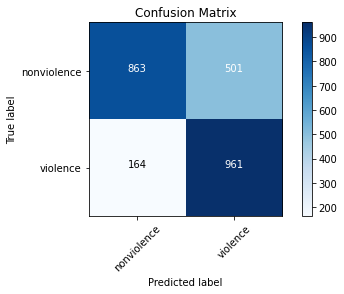

In [85]:
cm_plot_labels = ['nonviolence', 'violence']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Got 72% accuracy on the test set

### Testing - part of HTTP Live Streaming video

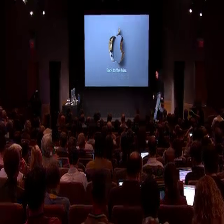

KeyboardInterrupt: ignored

In [ ]:
import cv2
import sys
import time
import numpy as np
from time import sleep
from matplotlib import pyplot as plt
from IPython.display import clear_output
from google.colab.patches import cv2_imshow

# VIDEO_URL = 'TData/violence/videoplayback_1_184.mp4'
VIDEO_URL = "http://qthttp.apple.com.edgesuite.net/1010qwoeiuryfg/sl.m3u8"

cap = cv2.VideoCapture(VIDEO_URL)
if (cap.isOpened() == False):
    print('!!! Unable to open URL')
    sys.exit(-1)

# retrieve FPS and calculate how long to wait between each frame to be display
fps = cap.get(cv2.CAP_PROP_FPS)
wait_ms = int(1000/fps)
print('FPS:', fps)

i = 0
image_array = np.array([])
status = ''
while(True):
    # read one frame
    ret, frame = cap.read()
    if not ret:
      break
    image = cv2.resize(frame,(H,W))
    clear_output()
    cv2_imshow(image)
    sleep(1)
    _,_,C = image.shape
    if i%8 == 0:
        image_array = image.reshape(1,H, W,C)
    else:
        image = image.reshape(1,H, W,C)
        # print(image_array.shape, image.shape)
        image_array = np.concatenate((image_array, image))
    if i%8 == 7:
        st = time.time()
        prediction = model.predict(np.expand_dims(image_array,axis = 0))
        print(time.time()-st,'time for prediction')
        pred = prediction[0]
        print(pred)
        val = pred.argmax()
        print(val)
        if val == 0:
          status = 'nonviolence'
        else:
          status = 'violence'
        image_array = np.array([])
        print(status)
        i = 0
        continue
    i = i+1